# validate results

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [19]:
import os
import argparse
from datetime import datetime

import numpy as np
import pandas as pd
from numpy.random import default_rng

from activitysim.cli import run
from activitysim.core import inject

from fru_utils import run_trip_mode_choice, comp_mode_shares

In [20]:
pd.set_option("max_columns", 500)

In [21]:
root_dir = "/mnt/c/Users/jan.zill/code/activitysim"
example_dir = os.path.join(root_dir, "test_example_mtc")

In [23]:
os.chdir(example_dir)

In [24]:
parser = argparse.ArgumentParser()
run.add_run_args(parser)
# args = parser.parse_args()
# parser.parse_args(['--sum', '7', '-1', '42'])
args = parser.parse_args(['-c', 'configs', '-o', 'output', '-d', 'data'])
#run.run(args)  # 2mins full example run
if not inject.is_injectable('preload_injectables'):
    from activitysim import abm  # register abm steps and other abm-specific injectables
run.handle_standard_args(args)  # possibly update injectables

In [25]:
# need to do this before loading checkpoint tables
trace_hh_ids = 1024353
#1024353 has trip id 642446345 (at least) where logsum and probs are different
#2821179  # has trip_ids 2464104881 and 2464104885
inject.add_injectable("trace_hh_id", trace_hh_ids)

In [187]:
%%time
trips_df_ru = run_trip_mode_choice()
trips_df = run_trip_mode_choice(choose_individual_max_utility=False)

register joint_tour_participants: no rows with household_id in [1024353].
estimation bundle trip_mode_choice not in settings file estimation.yaml


Running with %d trips 482
trip_mode_choice tour_type 'atwork' (27 trips)
trip_mode_choice tour_type 'eatout' (33 trips)
trip_mode_choice tour_type 'escort' (6 trips)
trip_mode_choice tour_type 'othdiscr' (43 trips)
trip_mode_choice tour_type 'othmaint' (46 trips)
trip_mode_choice tour_type 'school' (37 trips)
trip_mode_choice tour_type 'shopping' (77 trips)
trip_mode_choice tour_type 'social' (19 trips)
trip_mode_choice tour_type 'univ' (26 trips)
trip_mode_choice tour_type 'work' (168 trips)


register joint_tour_participants: no rows with household_id in [1024353].


Done


estimation bundle trip_mode_choice not in settings file estimation.yaml


Running with %d trips 482
trip_mode_choice tour_type 'atwork' (27 trips)
trip_mode_choice tour_type 'eatout' (33 trips)
trip_mode_choice tour_type 'escort' (6 trips)
trip_mode_choice tour_type 'othdiscr' (43 trips)
trip_mode_choice tour_type 'othmaint' (46 trips)
trip_mode_choice tour_type 'school' (37 trips)
trip_mode_choice tour_type 'shopping' (77 trips)
trip_mode_choice tour_type 'social' (19 trips)
trip_mode_choice tour_type 'univ' (26 trips)
trip_mode_choice tour_type 'work' (168 trips)
Done
CPU times: user 18.1 s, sys: 2.36 s, total: 20.5 s
Wall time: 17.3 s


In [188]:
c_ = ["trip_mode", "mode_choice_logsum"]
trips = trips_df_ru[c_].merge(trips_df[c_], left_index=True, right_index=True, how="outer", suffixes=["_fru", "_asim"])
pd.merge(trips_df_ru.trip_mode.value_counts(), trips_df.trip_mode.value_counts(), left_index=True, right_index=True,
         suffixes=["_fru", "_asim"])

,trip_mode_fru,trip_mode_asim
WALK,308,304
WALK_LOC,87,85
WALK_LRF,54,53
BIKE,15,17
TNC_SINGLE,7,4
DRIVEALONEFREE,5,4
SHARED2FREE,3,4
SHARED3FREE,2,1
WALK_HVY,1,4


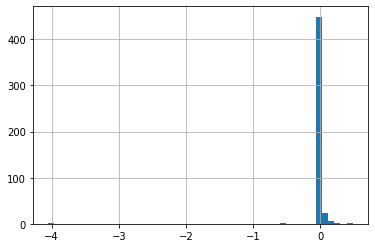

In [189]:
if np.allclose(trips.mode_choice_logsum_fru, trips.mode_choice_logsum_asim):
    print("Logsums agree")
else:
    ((trips.mode_choice_logsum_fru - trips.mode_choice_logsum_asim) / trips.mode_choice_logsum_fru).hist(bins=50)

In [190]:
ls_ = np.abs(((trips.mode_choice_logsum_fru - trips.mode_choice_logsum_asim) / trips.mode_choice_logsum_fru))
ls_.sort_values(ascending=False)

trip_id
106170305     4.050638
106170309     0.553496
1767013721    0.482067
535694461     0.251889
943749469     0.203583
                ...   
535672921     0.000000
535620049     0.000000
535388485     0.000000
535388481     0.000000
943749471     0.000000
Length: 482, dtype: float64

In [191]:
trips.loc[trips.index == 642446345]

,trip_mode_fru,mode_choice_logsum_fru,trip_mode_asim,mode_choice_logsum_asim
trip_id,,,,
642446345,WALK_LRF,1.634462,WALK_LRF,1.593075


In [192]:
#trips.loc[np.abs(trips.mode_choice_logsum_fru - trips.mode_choice_logsum_asim) > 0]

# Run MC validation

see logit._each_nest parent_nest_scale for leaf node, and simulate.compute_nested_utilities for discussion of scales
of alternatives

easiest way is to run a simulation

In [193]:
from fru_utils import get_stuff
t, ru, neu, nu, ns, nested_probs, base_probs = get_stuff()  #do_these_purposes=["social"])  #social

register joint_tour_participants: no rows with household_id in [1024353].
estimation bundle trip_mode_choice not in settings file estimation.yaml


Running with %d trips 482
trip_mode_choice tour_type 'atwork' (27 trips)
trip_mode_choice tour_type 'eatout' (33 trips)
trip_mode_choice tour_type 'escort' (6 trips)
trip_mode_choice tour_type 'othdiscr' (43 trips)
trip_mode_choice tour_type 'othmaint' (46 trips)
trip_mode_choice tour_type 'school' (37 trips)
trip_mode_choice tour_type 'shopping' (77 trips)
trip_mode_choice tour_type 'social' (19 trips)
trip_mode_choice tour_type 'univ' (26 trips)
trip_mode_choice tour_type 'work' (168 trips)
Done


In [194]:
#trips.loc[np.abs(trips.mode_choice_logsum_fru - trips.mode_choice_logsum_asim) > 0]

In [195]:
#t.loc[t.index.isin(trips.loc[np.abs(trips.mode_choice_logsum_fru - trips.mode_choice_logsum_asim) > 0].index.values)]\
#    .sort_values(by=["primary_purpose"])

In [196]:
# nest_spec = ns[0]
# for nest in logit.each_nest(nest_spec, post_order=False):
#     print(f"{nest.level}, {nest.name}, {nest.coefficient}, parent scale: {nest.parent_scale}")

In [197]:
#base_probs[7]  #615236801

In [198]:
t.loc[t.index == 642446345]

,person_id,household_id,primary_purpose,trip_num,outbound,trip_count,destination,origin,tour_id,purpose,destination_logsum,depart,trip_mode,mode_choice_logsum
trip_id,,,,,,,,,,,,,,
642446345,1958677,1024353,social,1,True,1,14,9,80305793,social,NaN,10.0,WALK_LRF,1.593075


In [ ]:
%%time

num_samples = 100
trip_id_to_check = 642446345  # 1e5 takes about 25s EDIT: BEFORE APPLY, now it's more like XXX and 1e4 takes 1m21s
#  work 615236801  also in trace log
#  social 2464104885 642446345 1767182945

bp = base_probs[7]   # 7 for social, 9 for work. Check t[t.index == trip_id_to_check] to see which purpose, and
# output above to see which index
# choose_individual_max_utility = False
#ms_comp = comp_mode_shares(bp, choose_individual_max_utility, num_samples, trip_id_to_check)
#display(ms_comp.loc[((ms_comp.mode_share_obs != 0) | (ms_comp.trip_mode != 0)), ["mode_share_obs", "trip_mode"]].T)

choose_individual_max_utility = True
ms_comp = comp_mode_shares(bp, choose_individual_max_utility, num_samples, trip_id_to_check)
display(ms_comp.loc[((ms_comp.mode_share_obs != 0) | (ms_comp.trip_mode != 0)), ["mode_share_obs", "trip_mode"]].T)

register joint_tour_participants: no rows with household_id in [1024353].
estimation bundle trip_mode_choice not in settings file estimation.yaml


Running with %d trips 482
trip_mode_choice tour_type 'social' (100 trips)


## try to improve runtime of apply

try caching {nest_name: nest alternatives}


In [239]:
nest_spec = ns[7]  # 7 is social
nest_util = nu[7].loc[nu[7].index == trip_id_to_check]

n = 10000

nest_util = nest_util.loc[nest_util.index.repeat(n)]
nest_util.index += np.arange(n)

display(base_probs[7].loc[base_probs[7].index == trip_id_to_check])

,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED
trip_id,,,,,,,,,,,,,,,,,,,,,
642446345,0.0,0.0,0.004883,0.0,4.701403e-14,0.0,0.044905,0.0,0.059962,0.889736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000096,0.000131,0.000287


In [240]:
%%time

from numpy.random import default_rng
from activitysim.core import logit

rng = default_rng(999)

def random_for_df(df):
    return rng.random(size=df.shape)

def add_ev1_random(df):
    uniform_rands = random_for_df(df)
    df = df + logit.inverse_ev1_cdf(uniform_rands)
    return df

nest_utils_for_choice = add_ev1_random(nest_util)

CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 21.1 ms


In [241]:
def group_nests_by_name(nest_spec):
    # group nests by level, returns {level: [nest.name at that level]}
    depth = np.max([x.level for x in logit.each_nest(nest_spec)])
    nest_levels = {x: [] for x in range(1, depth+1)}
    for n in logit.each_nest(nest_spec):
        nest_levels[n.level].append(n.name)
    return nest_levels

def make_choices_apply(nested_utilities, all_alternatives, logit_nest_groups, nest_alternatives_by_name):
    for level, nest_names in logit_nest_groups.items():
        if level == 1:
            next_level_alts = nest_alternatives_by_name[nest_names[0]]
            continue
        choice_this_level = nested_utilities[nested_utilities.index.isin(next_level_alts)].idxmax()
        if choice_this_level in all_alternatives:
            return choice_this_level
        next_level_alts = nest_alternatives_by_name[choice_this_level]
    raise ValueError("This should never happen - no alternative found")

In [242]:
all_alternatives = set(nest.name for nest in logit.each_nest(nest_spec, type='leaf'))
logit_nest_groups = group_nests_by_name(nest_spec)
nest_alternatives_by_name = {n.name: n.alternatives for n in logit.each_nest(nest_spec)}

choices_apply = nest_utils_for_choice.apply(
    lambda x: make_choices_apply(x, all_alternatives, logit_nest_groups, nest_alternatives_by_name),
    axis=1
)

In [243]:
choices_apply.value_counts() / n

WALK_LRF       0.8383
WALK_LOC       0.1158
WALK           0.0405
SHARED2FREE    0.0048
TNC_SHARED     0.0003
TAXI           0.0002
TNC_SINGLE     0.0001
dtype: float64

# stuff


In [172]:
from activitysim.core import pipeline

resume_after = "trip_scheduling"
model_name = "trip_mode_choice"
chunk_size = 0  # test_mtc means no chunking

pipeline.open_pipeline(resume_after)
# preload any bulky injectables (e.g. skims) not in pipeline
inject.get_injectable('preload_injectables', None)
pipeline._PIPELINE.rng().begin_step(model_name)
#step_name = model_name
args = {}
#checkpoint = pipeline.intermediate_checkpoint(model_name)
inject.set_step_args(args)

trips = inject.get_table('trips')
tours_merged = inject.get_table('tours_merged')
network_los = inject.get_injectable('network_los')

finalise = True
if finalise:
    inject.set_step_args(None)
    #
    pipeline._PIPELINE.rng().end_step(model_name)
    pipeline.add_checkpoint(model_name)
    if not pipeline.intermediate_checkpoint():
        pipeline.add_checkpoint(pipeline.FINAL_CHECKPOINT_NAME)

    pipeline.close_pipeline()

register joint_tour_participants: no rows with household_id in [982875].


In [176]:
t_ = trips.to_frame()

In [177]:
t_.loc[t_.index == 2464104885]

,person_id,household_id,primary_purpose,trip_num,outbound,trip_count,destination,origin,tour_id,purpose,destination_logsum,depart
trip_id,,,,,,,,,,,,
2464104885,7512514,2821179,social,1,False,1,8,9,308013110,home,NaN,16.0
